In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
import matplotlib
import matplotlib as mpl
import re
import geopandas
import cmocean

import dask
import os
import sys
sys.path.insert(0, '/net/fs11/d0/emfreese/BC-IRF/')
import utils
import plotting_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
countries = ['MALAYSIA','CAMBODIA','INDONESIA','VIETNAM']

## Add time dimension
days_per_year = 365

length_simulation = utils.years*days_per_year
time_array = np.arange(0, length_simulation)
shutdown_years = np.arange(2000,2061,1)

In [3]:
###### Import prepared plant data #######
CGP_df = pd.read_csv(f'{utils.data_output_path}plants/BC_SE_Asia_all_financing_SEA_GAINS_Springer_plus_rad.csv', index_col = [0])
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})
min_year = CGP_df['Year_of_Commission'].min()

##remove any plants that have no data on commission year
CGP_df = CGP_df.loc[CGP_df['Year_of_Commission'].dropna().index]
print('Emis data prepped and loaded')


######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
country_df = geopandas.read_file(f'{utils.raw_data_in_path}/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
impacted_countries = ['China','Australia', 'India','Myanmar', 'Cambodia', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan','Brunei','Singapore', 'Papua New Guinea', 'Solomon Islands', 'East Timor', 'Taiwan', 'Malaysia','Cambodia', 'Vietnam','Indonesia']
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


Emis data prepped and loaded


/tmp/ipykernel_3148122/2588551519.py:15: UserWarning: `land_50` of `natural_earth_v4_1_0` and `natural_earth_v5_0_0` does not quite extend to 90°S - it's recommended to use `natural_earth_v5_1_2` instead. See https://github.com/regionmask/regionmask/issues/487
  country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50


In [4]:
#convert from g/day to g/yr

CGP_df['BC_(g/yr)'] = CGP_df['BC_(g/day)'] * days_per_year #g/year
CGP_df.drop(columns = ['BC_(g/day)', 'BC_(kg/m2/year)'], inplace = True)

In [5]:
ARTP = pd.read_csv(f'{utils.data_output_path}/ARTP_processed.csv')
#take mean across winter and summer, assuming each season is 50% of the forcing
ARTP = ARTP.groupby(['Location','t_horizon',]).mean('Emis_season')

In [6]:
# Multiply the ARTP by the emissions
lhs  = pd.DataFrame(CGP_df['BC_(g/yr)'])
ARTP.index = ['{}_{}'.format(i, j) for i, j in ARTP.index]
rhs = pd.DataFrame(ARTP.transpose())
empty_df = pd.DataFrame(data = None, index = lhs.index, columns = rhs.columns).fillna(1)
k_em = empty_df*rhs.loc['BC_K_g']
em_yr = (empty_df.transpose()* lhs.transpose().loc['BC_(g/yr)']).transpose()
k_g = k_em*em_yr

/tmp/ipykernel_3148122/2767321851.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_df = pd.DataFrame(data = None, index = lhs.index, columns = rhs.columns).fillna(1)


In [7]:
## Get the warming values and combine with our emissions data
# Function to extract number from column name
def get_number_from_column(col_name):
    match = re.search(r'_(\d+)$', col_name)  
    if match:
        return int(match.group(1))
    return None


# Iterate through columns and divide by number if found
for col in k_g.columns:
    number = get_number_from_column(col)
    if number is not None:
        k_g[col] = k_g[col] / number

In [8]:
CGP_df = pd.concat([CGP_df, k_g], axis = 1)

#add in the radiative forcing by location (need to get citation)
Tg_per_ug = 1e18
rad_force_dict = {'MALAYSIA': 1.32e-2/Tg_per_g, 'INDONESIA':1.17e-2/Tg_per_g, 'VIETNAM':1.30e-2/Tg_per_g, 'CAMBODIA':1.81e-2/Tg_per_g} #units = W/m2/Tg  BC

for c in rad_force_dict.keys():
    CGP_df.loc[CGP_df['COUNTRY'] == c,'rad_forcing_wperm2perkg'] = rad_force_dict[c]

In [9]:
#calculate the years of operation, emissions for that amount of time, and radiative forcing over that time for all plants (if they are running for up to 40 years or less)
E_CO2_all_opts = {}

#for each early shutdown year
for yr in shutdown_years:
    #calculate the years until shutdown for each plant
    E_CO2_all_opts[yr] = ((yr- CGP_df.loc[(CGP_df['BC_(g/yr)'] >0)]['Year_of_Commission'] ))
    #make datasets
    E_CO2_all_opts[yr] = xr.DataArray(data = E_CO2_all_opts[yr].values,
                                dims = ['unique_ID'],
                                coords = dict(unique_ID = 
                                              CGP_df.loc[(CGP_df['BC_(g/yr)'] >0)].index),
                                attrs = dict(description = 'years that each power plant operates under a given early shutdown',
                                            units = 'yrs'))
    

    #make sure the plants are operating, and that they don't exceed their lifetime (estimated 40 years)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] > 0).fillna(0)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] <= 40).fillna(40)

#concatenate into a dataset
shutdown_ds= xr.concat([E_CO2_all_opts[m] for m in E_CO2_all_opts.keys()], pd.Index([m for m in E_CO2_all_opts.keys()], name='scenario_year'), join = 'outer')


In [10]:
shutdown_single_yr_ds = xr.ones_like(shutdown_ds)

In [11]:
country_id_ds = CGP_df.loc[CGP_df['BC_(g/yr)'] >0].groupby('unique_ID').first().to_xarray() 

In [12]:
ug_to_ng = 1e3

for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(g/yr)'] >0)]['unique_ID'].values:
        print(c, unique_id)

In [13]:
### import the convolutions 
conv_df = {}
for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(g/yr)'] >0)]['unique_ID'].values:
        path = f'{utils.data_output_path}convolution/convolution_{c}_{unique_id}_uniqueid.nc'
        if os.path.exists(path):
            conv_df[unique_id] = pd.read_csv(path, index_col = 0)
            conv_df[unique_id] = conv_df[unique_id].to_xarray().rename({'index':'country_impacted'})
        else:
            print(f'missing {c} {unique_id}')


# Concatenate all the convolution dataframes into a single xarray dataset   
conv_ds = xr.concat([conv_df[t] for t in conv_df.keys()], pd.Index([t for t in conv_df.keys()], name='unique_ID'), join = 'outer')#*ug_to_ng

In [14]:
### Name the datasets and add attributes        
shutdown_ds.name = 'plants_shutdown'
shutdown_single_yr_ds.name = 'remaining_plants'

shutdown_ds.attrs['units'] = 'none'
shutdown_single_yr_ds.attrs['units'] = 'none'

In [15]:
### rename variables to be more readable  

def is_string_dtype(dtype):
    return dtype.kind in {'U', 'S', 'O', 'i'}

# Select non-string variables
non_string_vars = {var: country_id_ds[var] for var in country_id_ds.data_vars 
                   if not is_string_dtype(country_id_ds[var].dtype)}      
reduced_id_ds = country_id_ds[non_string_vars.keys()].rename({'ANNUALCO2':'co2_emissions', 'MW':'MW_total',  'snowrf_toa':'snowrf', 'drf_toa':'drf', 'dt_snowrf':'dt_snowrf','dt_drf':'dt_drf'})

In [16]:
### Remove some variables that are repeats
var_drop_list = ['Unnamed:_0', 'UNITID', 'UNIT', 'PLANT', 'COMPANY', 'MW', 
                 'STATUS', 'Year_of_Commission', 'UTYPE', 'FUEL', 'FUELTYPE', 
                 'ALTFUEL', 'SSSMFR', 'BOILTYPE', 'TURBMFR', 'TURBTYPE', 'GENMFR', 
                 'GENTYPE', 'SFLOW', 'SPRESS', 'STYPE', 'STEMP', 'REHEAT1', 'REHEAT2', 
                 'PARTCTL', 'PART.BAT', 'PARTMFR', 'SO2CTL', 'SO2.BAT', 'FGDMFR', 'NOXCTL', 'NOX.BAT', 
                 'NOXMFR', 'AE', 'AE.COUNTRY', 'AE.CHINA', 'CONSTRUCT', 'CON.COUNTRY', 'CON.CHINA', 'COOL', 
                 'RETIRE', 'CITY', 'STATE', 'AREA', 'SUBREGION', 'POSTCODE', 'PARENT', 'PAR.COUNTRY', 
                 'PAR.CHINA', 'ELECTYPE', 'BUSTYPE', 'COMPID', 'LOCATIONID', 'HEATRATE.UNADJ', 
                 'CO2_weighted_capacity_1000tonsperMW', 'CAPFACTOR', 'ANNUALCO2', 'EMISFACTOR.GCPT', 
                 'HEATRATE.ADJ', 'COAL', 'EMISFACTOR.CO2', 'HEATRATE', 'EMISFACTOR.BC.GAINS', 
                 'EMISFACTOR.BC.GAINS.g_mwh', 'MWh_daily', 'location_key', 'latitude', 'longitude', 
                 'grid_area_m2']

In [17]:
#multiple the timeline datasets and convolutions by the emissions/radiation datasets, this will give us the cumulative amount
vars_ds = shutdown_ds*reduced_id_ds

#single year impact
vars_single_ds = shutdown_single_yr_ds*reduced_id_ds

#multiply the convolution
conv_shutdown_ds = conv_ds * shutdown_ds
conv_single_ds = conv_ds * shutdown_single_yr_ds

# drop the variables that are not needed if they are in the var_ds or vars_single_ds
var_ds_drop = [var for var in var_drop_list if var in vars_ds.data_vars]
vars_ds = vars_ds.drop(var_ds_drop)

#create a single year impact
vars_single_ds_drop = [var for var in var_drop_list if var in vars_single_ds.data_vars]
vars_single_ds = vars_single_ds.drop(vars_single_ds_drop)

/tmp/ipykernel_3148122/1136870500.py:13: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vars_ds = vars_ds.drop(var_ds_drop)
/tmp/ipykernel_3148122/1136870500.py:17: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vars_single_ds = vars_single_ds.drop(vars_single_ds_drop)


rad_force_ds = country_id_ds['rad_forcing_wperm2perkg']*Emis_ds

k_per_tg_per_yr = 0.04 #https://acp-copernicus-org.libproxy.mit.edu/articles/20/3079/2020/ Sand et al.
temp_ds = Emis_ds/Tg_per_kg

conv_dsrad_force_ds.name = 'BC_forcing'
rad_force_ds.attrs = {'units':'W/m2'}

temp_ds.name = 'BC_temp'
temp_ds.attrs = {'units':'K'} 

In [18]:
# Create a merged dataset
scenario_ds = xr.merge([country_id_ds.drop(['ANNUALCO2',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)',
                                                'Global_10',
                                                'Global_20',
                                                'Global_50',
                                                'Global_100',
                                                'N_arctic_10',
                                                'N_arctic_20',
                                                'N_arctic_50',
                                                'N_arctic_100',
                                                'N_midlat_10',
                                                'N_midlat_20',
                                                'N_midlat_50',
                                                'N_midlat_100',
                                                'S_subtropics_10',
                                                'S_subtropics_20',
                                                'S_subtropics_50',
                                                'S_subtropics_100',
                                                'Tropics_10',
                                                'Tropics_20',
                                                'Tropics_50',
                                                'Tropics_100']), 
                    vars_ds, 
                    conv_shutdown_ds]).rename({'COUNTRY':'country_emitting'})



# Create a merged dataset for single year data
single_year_ds = xr.merge([country_id_ds.drop(['ANNUALCO2',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'BC_(g/yr)',
                                                'Global_10',
                                                'Global_20',
                                                'Global_50',
                                                'Global_100',
                                                'N_arctic_10',
                                                'N_arctic_20',
                                                'N_arctic_50',
                                                'N_arctic_100',
                                                'N_midlat_10',
                                                'N_midlat_20',
                                                'N_midlat_50',
                                                'N_midlat_100',
                                                'S_subtropics_10',
                                                'S_subtropics_20',
                                                'S_subtropics_50',
                                                'S_subtropics_100',
                                                'Tropics_10',
                                                'Tropics_20',
                                                'Tropics_50',
                                                'Tropics_100']), 
                    vars_single_ds, 
                    conv_single_ds]).rename({'COUNTRY':'country_emitting'})


/tmp/ipykernel_3148122/1371112313.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  scenario_ds = xr.merge([country_id_ds.drop(['ANNUALCO2',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)',
/tmp/ipykernel_3148122/1371112313.py:29: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  single_year_ds = xr.merge([country_id_ds.drop(['ANNUALCO2',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'BC_(g/yr)',


##### Convert to Geopandas Dataframe for mapping

In [19]:
gdf = country_df[country_df['country'].isin(impacted_countries)][['country','geometry']].rename(columns = {'country':'country_impacted'}).set_index('country_impacted')

In [20]:
map_locations = ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']
shutdown_years = np.arange(2030, 2060, 10)

# Without normalization
regular_data = plotting_utils.prepare_concentration_data(
    scenario_ds, gdf,
    map_locations, 
    shutdown_years
)

# With normalization
normalized_data = plotting_utils.prepare_concentration_data(
    scenario_ds, gdf,
    map_locations, 
    shutdown_years,
    normalize=True,
    emissions_df=CGP_df  # Pass your emissions dataframe
)


##### Prepare the temperature relationship for each receiving country


In [21]:
# Get the centroid latitude for each impacted country
country_latitudes = {}

# Extract latitude from country_df which already has the geometries
for _, row in country_df[country_df['country'].isin(impacted_countries) & country_df['ADMIN'].isin(impacted_countries)].iterrows():
    # Calculate the centroid of the country's geometry
    centroid = row['geometry'].centroid
    country_latitudes[row['country']] = centroid.y


dict_latitudes_region = {'N_arctic': [60,90], 'N_midlat': [28,60], 'Tropics': [-28,28], 'S_subtropics': [-90,-28]}


# Function to determine which region a latitude belongs to
def get_latitude_region(latitude, region_dict):
    for region_name, lat_range in region_dict.items():
        min_lat, max_lat = lat_range
        if min_lat <= latitude <= max_lat:
            return region_name
    return None  # Return None if latitude doesn't fall within any defined region


# Map each country to its region based on its latitude
country_to_region = {}
for country, latitude in country_latitudes.items():
    region = get_latitude_region(latitude, dict_latitudes_region)
    country_to_region[country] = region

regions_vars_dict = {}
for region in list(dict_latitudes_region.keys()):  # Use keys instead of values
    regions_vars_dict[region] = [var for var in scenario_ds.data_vars 
                if region in var]
    


for yy in [10, 20, 50, 100]:
    single_year_ds[f'temperature_impact_aamaas_{yy}'] = xr.zeros_like(single_year_ds['BC_pop_weight_mean_conc'])
    for country in single_year_ds.country_impacted.values:
        single_year_ds[f'temperature_impact_aamaas_{yy}'].loc[dict(country_impacted=country)] = single_year_ds.loc[dict(country_impacted =country)][[country_to_region[country]][0] + f'_{yy}']

    scenario_ds[f'temperature_impact_aamaas_{yy}'] = xr.zeros_like(scenario_ds['BC_pop_weight_mean_conc'])
    for country in scenario_ds.country_impacted.values:
        scenario_ds[f'temperature_impact_aamaas_{yy}'].loc[dict(country_impacted=country)] = scenario_ds.loc[dict(country_impacted =country)][[country_to_region[country]][0] + f'_{yy}']



map_locations = ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']
shutdown_years = np.arange(2030, 2060, 10)
temp_data = {}
normalized_temp_data = {}

for yy in [10, 20, 50, 100]:    

    # Without normalization
    temp_data[yy] = plotting_utils.prepare_concentration_data(
        scenario_ds, gdf,
        map_locations, 
        shutdown_years,
        variable = f'temperature_impact_aamaas_{yy}'
    )

    # With normalization
    normalized_temp_data[yy] = plotting_utils.prepare_concentration_data(
        scenario_ds, gdf,
        map_locations, 
        shutdown_years,
        variable = f'temperature_impact_aamaas_{yy}',
        normalize=True,
        emissions_df=CGP_df  # Pass your emissions dataframe
    )



## Maps

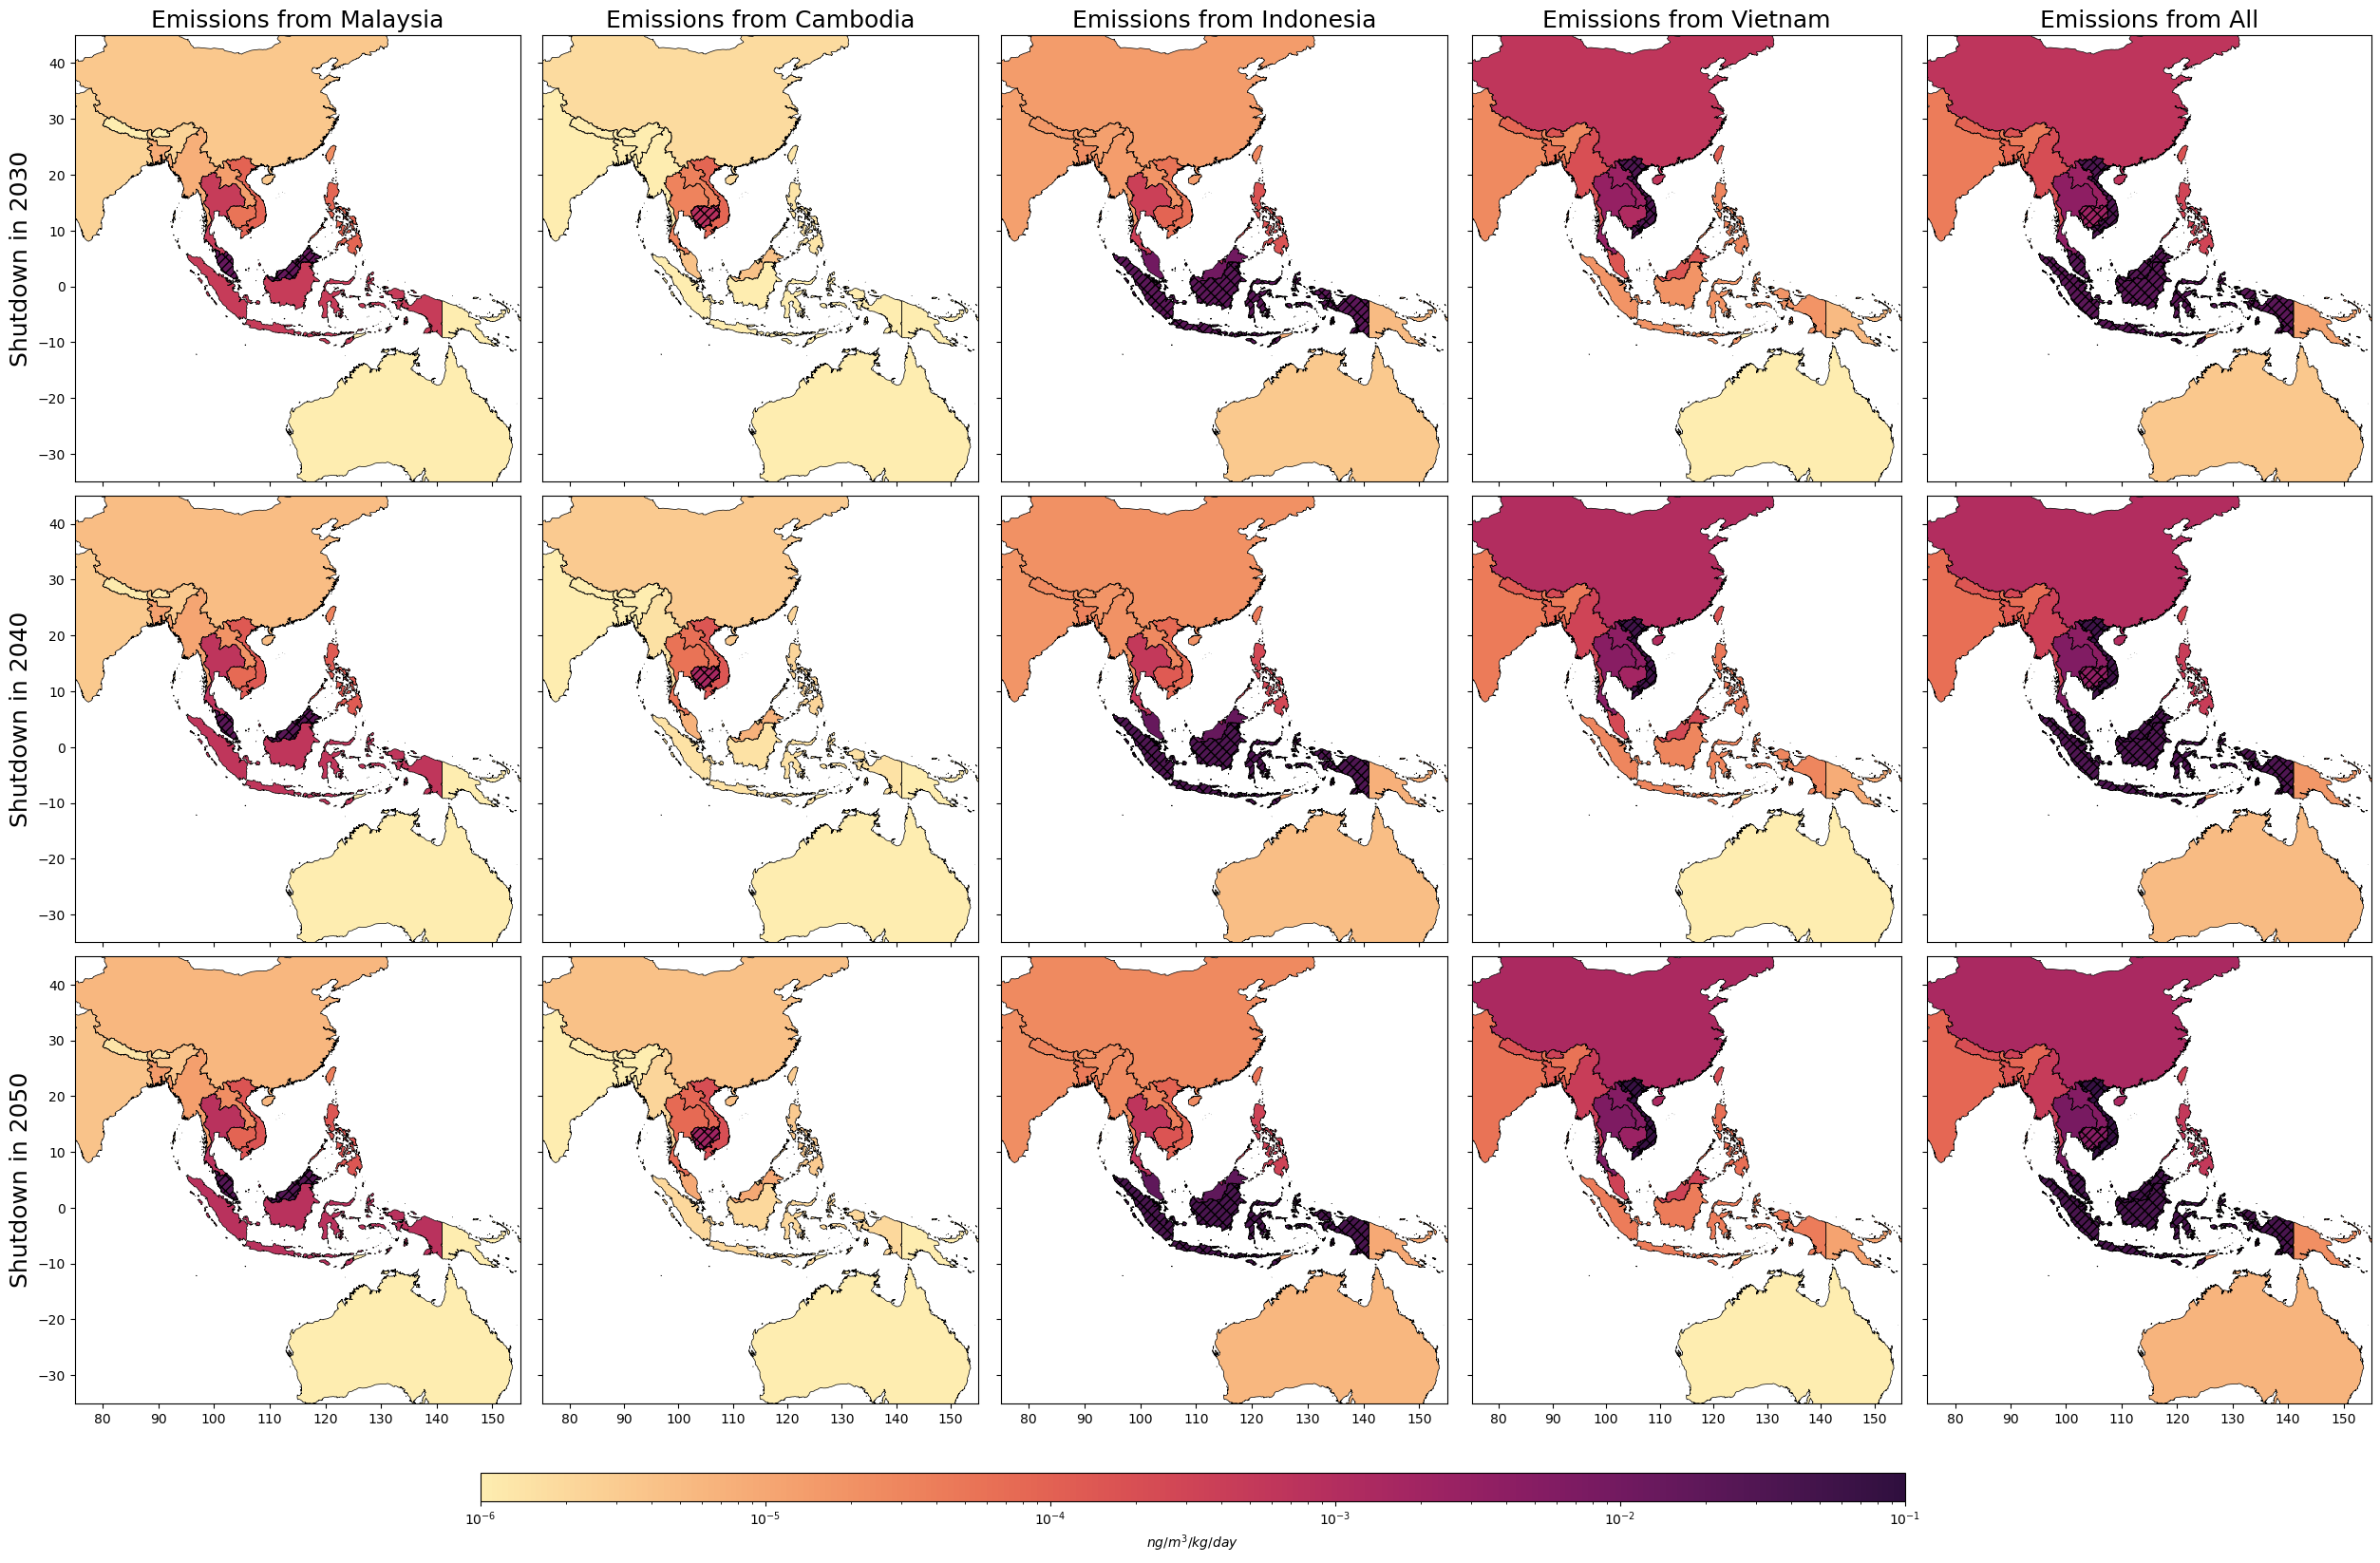

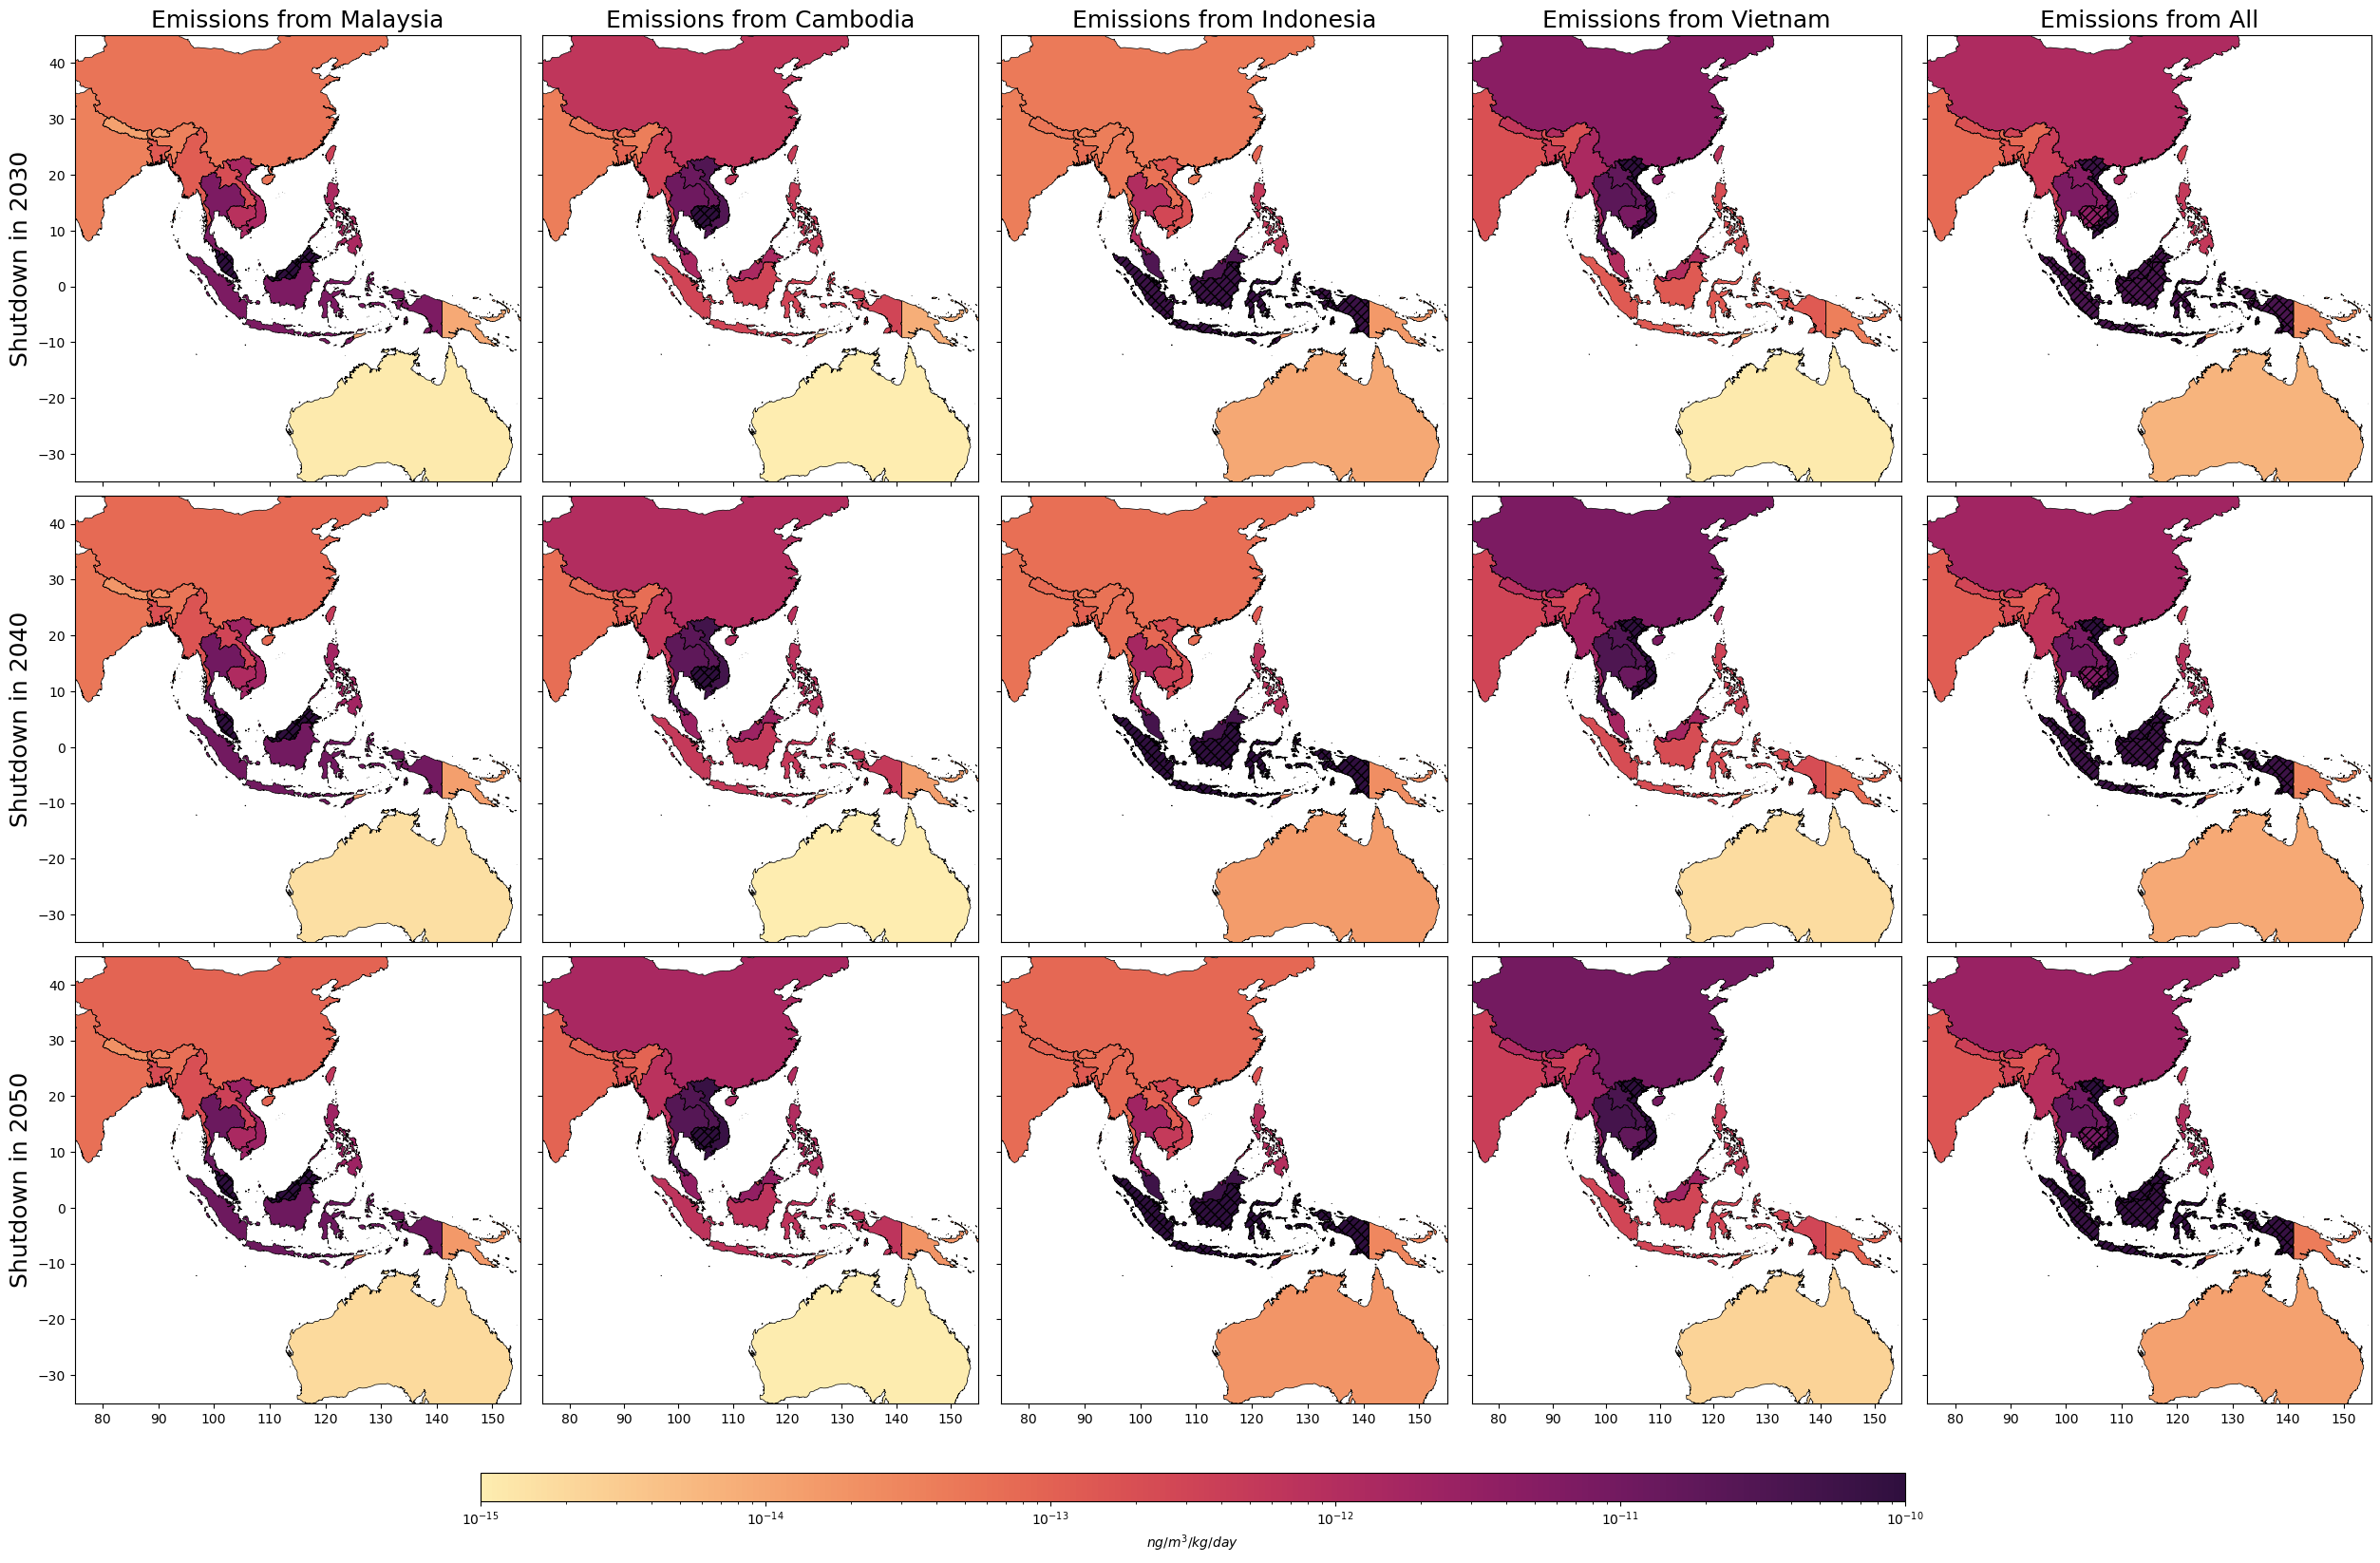

In [ ]:

# Plot regular data
fig1, axes1 = plotting_utils.plot_concentration_maps(
    regular_data, 
    map_locations, 
    shutdown_years,
    impacted_countries,
    country_df,
    variable='BC_pop_weight_mean_conc',
    save_path = '../figures/paper/maps/BC_concentration_maps.png'

)

# Plot normalized data
fig2, axes2 = plotting_utils.plot_concentration_maps(
    normalized_data, 
    map_locations, 
    shutdown_years,
    impacted_countries,
    country_df,
    variable='BC_pop_weight_mean_conc',
    vmin=1e-15,  
    vmax=1e-10,
    save_path = '../figures/paper/maps/BC_concentration_maps_normalized.png'
)


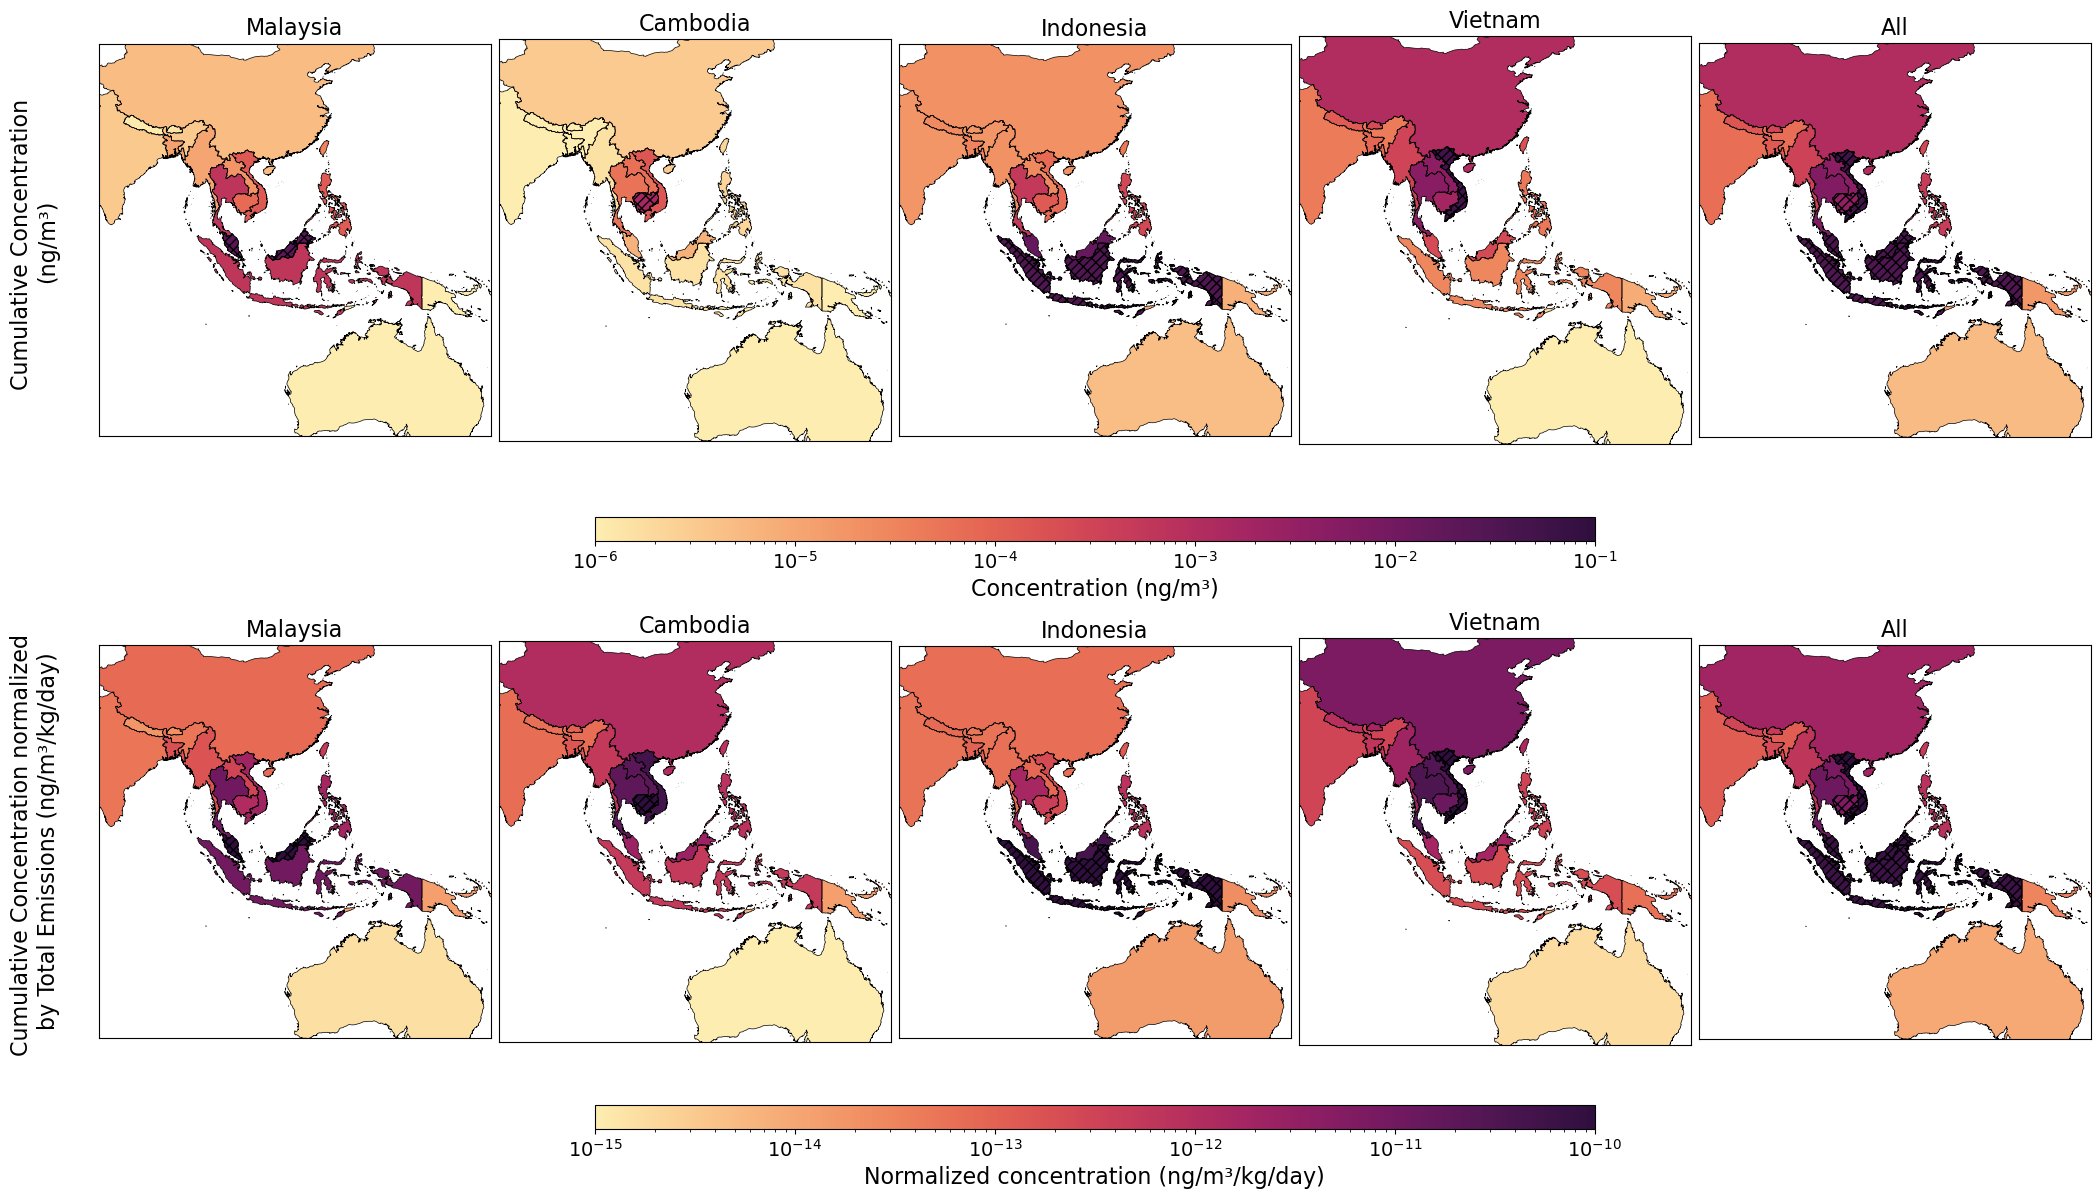

In [ ]:
yr = 2040
plotting_utils.plot_single_year_concentration_maps(
    regular_data,
    normalized_data, 
    map_locations, 
    yr,
    impacted_countries,
    country_df,
    variable='BC_pop_weight_mean_conc',
    vmin_regular=1e-6, vmax_regular=1e-1,
    vmin_norm=1e-15,  
    vmax_norm=1e-10,
    save_path = f'../figures/paper/maps/BC_concentration_maps_normalized_regular_{yr}.png'
);
plt.close()

## Vietnam Trajectories

In [110]:
for country in ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM']:
    for impacted_country in ['Thailand', 'Vietnam', 'Laos', 'Cambodia']:
        fig, axs, co2_data = plotting_utils.compare_vietnam_strategies_and_rates(
            single_year_ds,
            rates=[0.5, 2.0, 4.0, 10.0],
            force_closure_by=2040,
            strategies=['Year_of_Commission', 'MW', 'CO2_weighted_capacity_1000tonsperMW'],
            impact_var='BC_pop_weight_mean_conc',
            impacted_country= impacted_country,
            country = country
        )
        
        # Save the figure if needed
        plt.savefig(f'../figures/paper/timeline_plots/{country}_to_{impacted_country}_combined_strategies_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()

## Sankey Diagram

In [116]:
for yy in [10, 20, 50, 100]:     
    fig = plotting_utils.create_sankey_from_map_data(regular_data, norm_data=normalized_data, temp_data=temp_data[yy], temp_norm_data=normalized_temp_data[yy],
                                year=2040, location='all', 
                                variable='BC_pop_weight_mean_conc', temp_variable=f'temperature_impact_aamaas_{yy}',
                                top_n=8, allow_loops=False)
    fig.write_image(f"../figures/paper/sankey/sankey_diagram_2040_{yy}_timescale.png", width=1100, height=800, scale = 2) 
    #fig.show()


## Temperature, Emissions, Concentration over Time

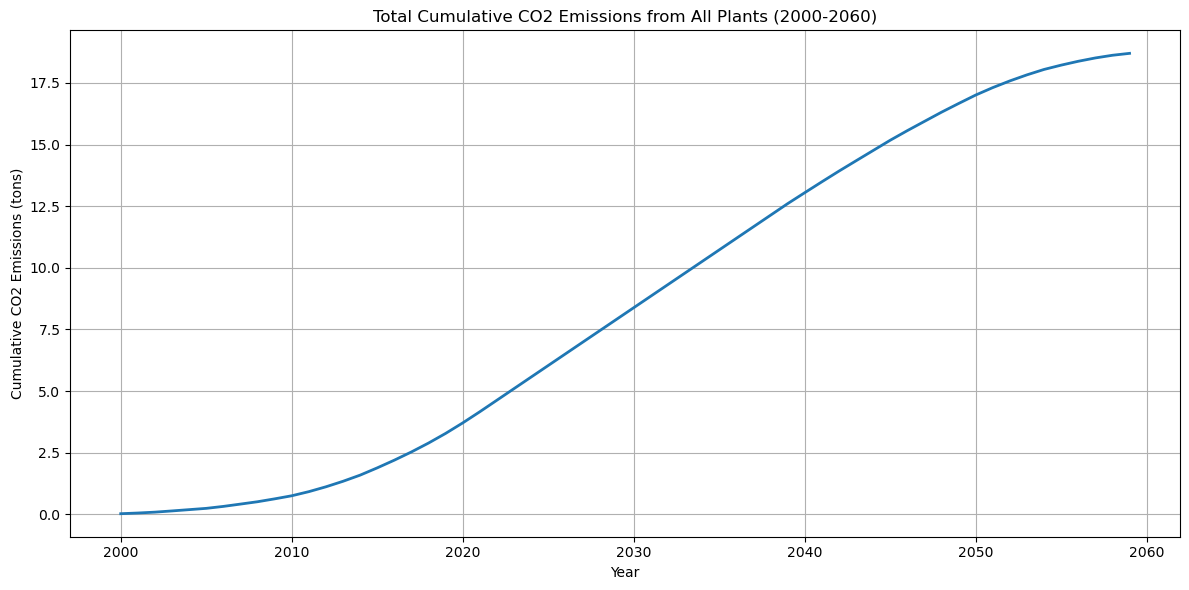

In [57]:
# Set up time array from 2000 to 2060
start_year = 2000
end_year = 2060
years = end_year - start_year
length_simulation = years * 365
time_array = np.arange(0, length_simulation)

# Calculate total CO2 emissions over time
total_emissions = np.zeros(length_simulation)
for unique_id in CGP_df['unique_ID'].values:
    # Get plant data
    plant_data = CGP_df.loc[CGP_df['unique_ID'] == unique_id]
    
    # Calculate annual CO2 emissions (in tons)
    annual_co2 = plant_data['ANNUALCO2']/1e9
    
    # Convert to daily emissions
    daily_co2 = annual_co2 / 365  # tons per day
    
    # Add to total emissions
    yr_offset = (plant_data['Year_of_Commission'].iloc[0] - start_year)
    if yr_offset >= 0:  # Only include plants commissioned after 2000
        test_array = np.where((time_array <= (yr_offset + 40)*365) & (time_array >= yr_offset * 365), True, False)
        total_emissions += test_array * daily_co2.values[0]

# Convert daily emissions to yearly and take cumulative sum
yearly_emissions = total_emissions.reshape(years, 365).sum(axis=1)
cumulative_emissions = np.cumsum(yearly_emissions)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(np.arange(start_year, end_year), cumulative_emissions, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Cumulative CO2 Emissions (tons)')
plt.title('Total Cumulative CO2 Emissions from All Plants (2000-2060)')
plt.grid(True)
plt.tight_layout()
plt.show()

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:1949: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



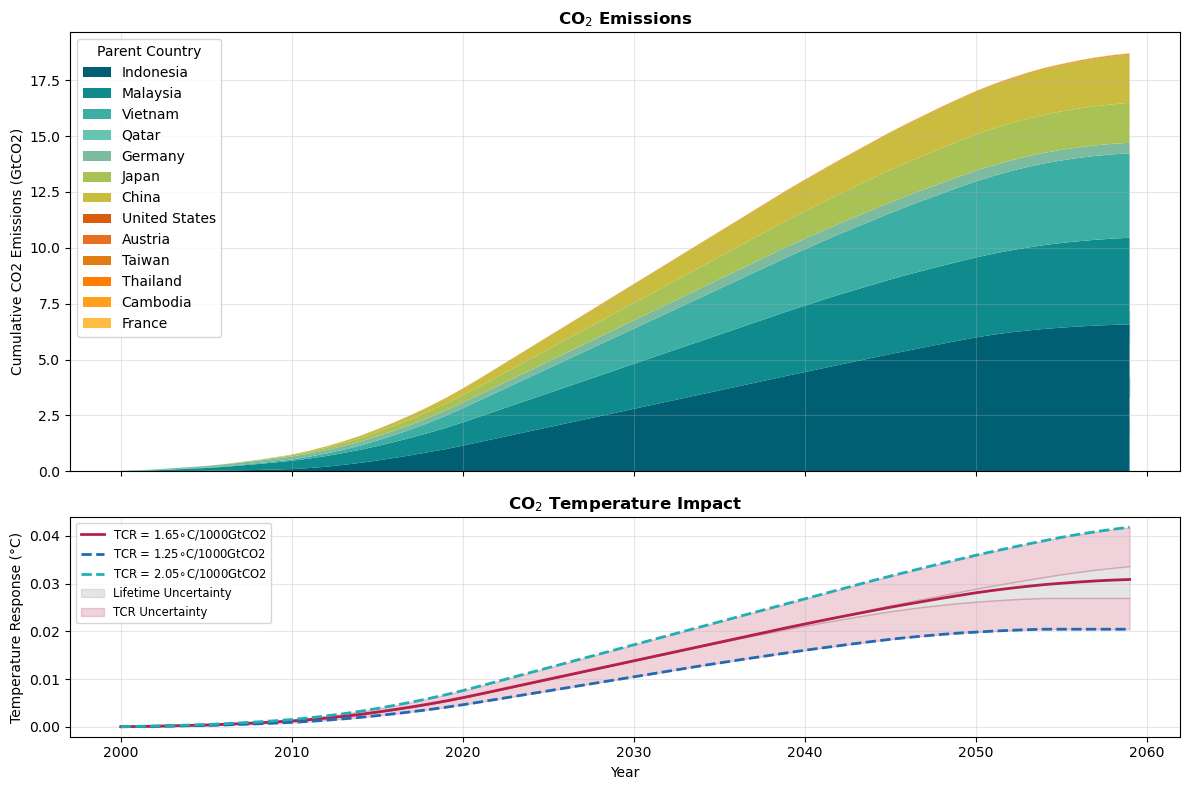

In [120]:
color_palette = {
    0: '#005F73',   # Dark Teal Blue
    1: '#0F8B8D',   # Dark Teal
    2: '#3CAEA3',   # Aqua
    3: '#68C3B1',   # Mint
    4: '#7CBB9F',   # Light Sage
    5: '#A8C256',   # Yellow-Green
    6: '#C9BC3F',   # Olive Yellow
    7: '#D85E0D',   # Dark Orange
    8: '#E66F20',   # Rust Orange
    9: '#E07C10',   # Burnt Orange
    10: '#FF7D00',  # Vivid Orange
    11: '#FF9F1C',  # Amber
    12: '#FFBC42',  # Deep Yellow
    13: '#FFDA44',  # Mustard Yellow
    14: '#FFF07C'   # Pale Yellow
}
# Breakdown by parent country
emissions, temp = plotting_utils.plot_emissions_and_temperature(
    CGP_df, 
    breakdown_by='PAR.COUNTRY', 
    colors_in=color_palette
)


# Get all axes from the current figure
axes = plt.gcf().get_axes()

# Add a title to the first legend (emissions plot, upper left subplot)
legend = axes[0].get_legend()
if legend:
    legend.set_title('Parent Country')

plt.tight_layout()
plt.savefig('../figures/paper/temperature_emissions/CO2_breakdown_by_parent_country.png', dpi=300, bbox_inches='tight')

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2627: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2628: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2629: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2630: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



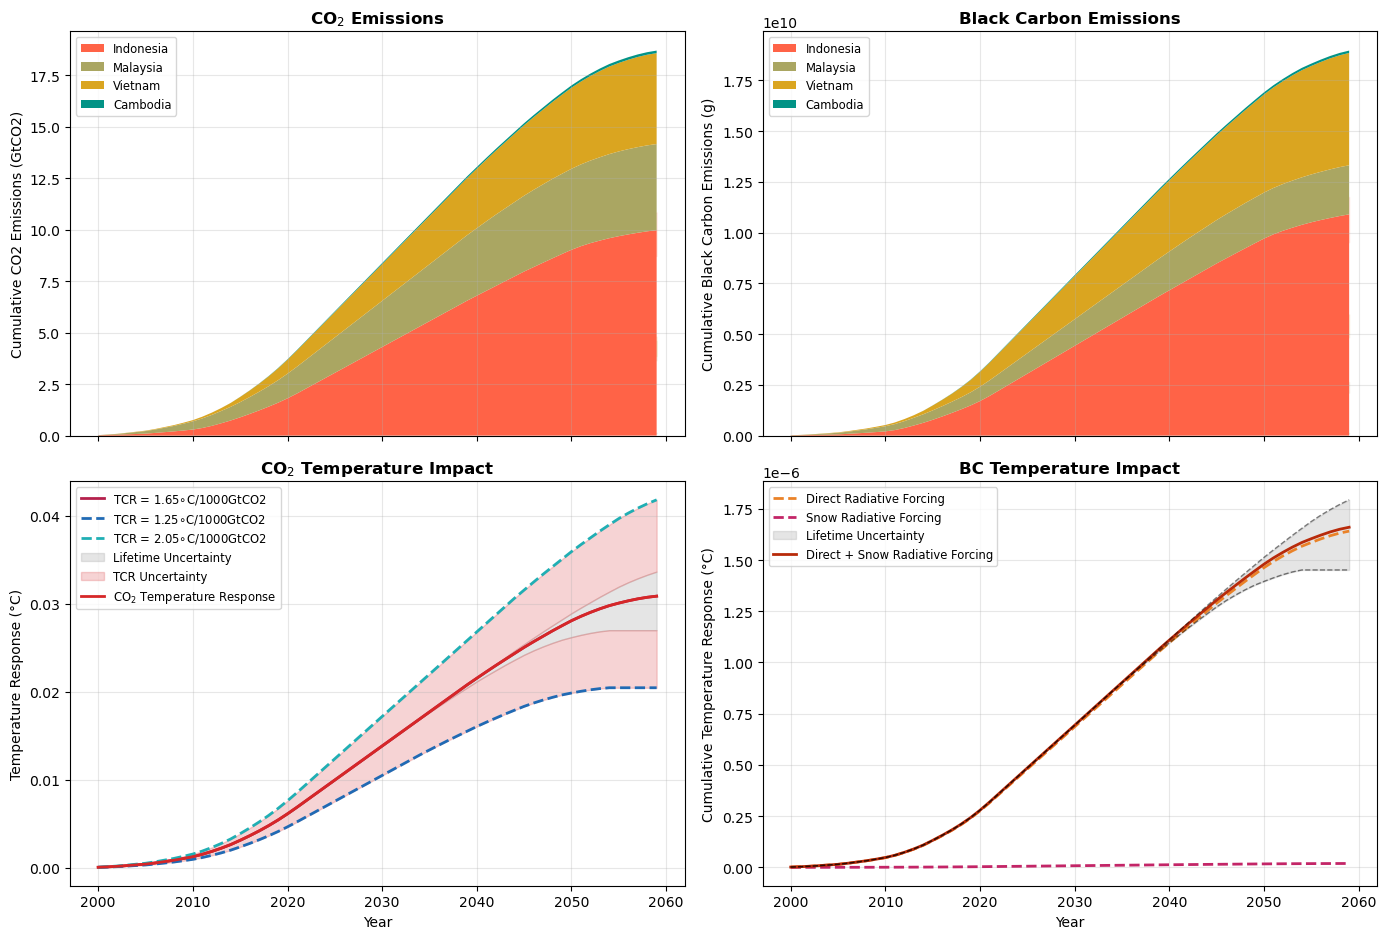

In [121]:
cumulative_emissions, co2_temp_response, cumulative_bc_emissions, cumulative_dt_drf, cumulative_dt_snowrf, total_bc_temp_response, total_temp_response = plotting_utils.plot_emissions_and_temperature_with_bc(
    CGP_df, 
    breakdown_by='COUNTRY'
)
plt.savefig('../figures/paper/temperature_emissions/BC_raisanen_breakdown_by_country.png', dpi=300, bbox_inches='tight')

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2220: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2221: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2224: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2225: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:2226: FutureWarning:

Calling float on a single element Series is depre

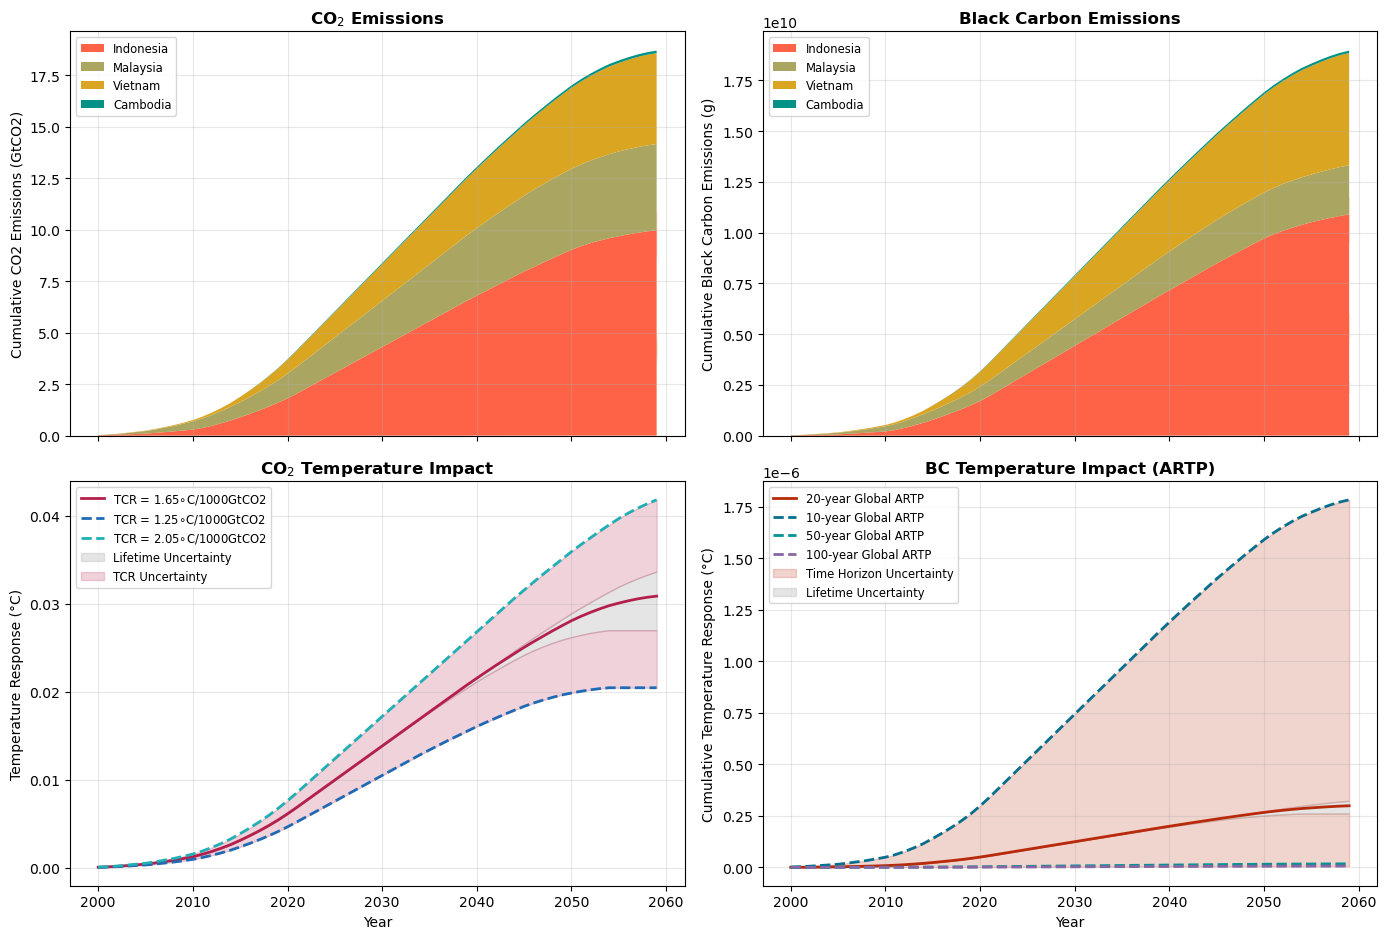

In [122]:
# With breakdown by country
emissions, co2_temp, bc_emissions, bc_temp_global20, bc_temp_other, total_temp = plotting_utils.plot_emissions_and_temperature_with_bc_artp(CGP_df, breakdown_by='COUNTRY')
plt.savefig('../figures/paper/temperature_emissions/BC_artp_breakdown_by_country.png', dpi=300, bbox_inches='tight')